In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import argparse
import torch
from tqdm import tqdm

import sys
sys.path.append('../')
from PhaseReductionNet import Encoder, Decoder, LatentSteper

plt.rcParams['font.family'] = 'Times New Roman' # font familyの設定
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["font.size"] = 30 

def to_polar(x):
    theta = torch.atan2(x[:, 1], x[:, 0])
    return theta

In [2]:
device = 'cuda'
enc = Encoder(input_dim=4,output_dim=3,hidden_dim = 100)
step = LatentSteper(zd = 1)
dec = Decoder(input_dim=3,output_dim=4,hidden_dim = 100)

model = 'HH'
result_dir = f'../out/HH/'

enc.load_state_dict(torch.load(os.path.join(result_dir,'enc.pth')))
step.load_state_dict(torch.load(os.path.join(result_dir,'step.pth')))
dec.load_state_dict(torch.load(os.path.join(result_dir,'dec.pth')))

enc.to(device)
step.to(device)
dec.to(device)

enc.eval()
step.eval()
dec.eval()
print(step.state_dict())
w = step.state_dict()['theta'].item()
print(w)

X0 = np.load(f'../data/limit_cycle_{model}.npy')
Z0 = np.load(f'../data/phase_response_function_{model}.npy')
print(X0.shape)
mean = np.mean(X0,axis=0)
std = np.std(X0,axis=0)
print(mean,std)

OrderedDict([('theta', tensor(-0.3101, device='cuda:0')), ('lam', tensor([0.7141], device='cuda:0'))])
-0.3101453185081482
(10128, 4)
[-51.47115444   0.2564294    0.22857994   0.5627105 ] [23.38956258  0.3164987   0.09296094  0.09463719]


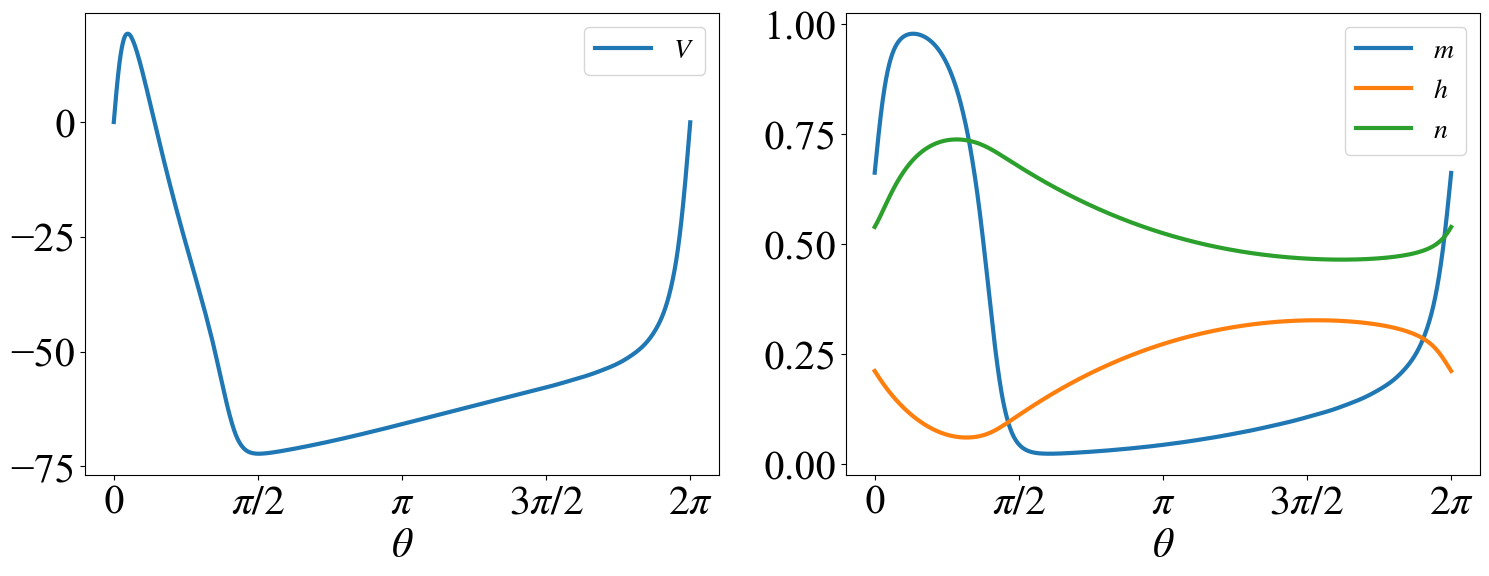

In [3]:
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.plot(np.linspace(0,2*np.pi,len(X0)),X0[:,0],label=r'$V$',lw=3)
plt.xticks([0,0.5*np.pi,np.pi,1.5*np.pi,2*np.pi],\
               [r'0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'])
plt.xlabel(r'$\theta$')
plt.legend(fontsize=20)
plt.subplot(1,2,2)
plt.plot(np.linspace(0,2*np.pi,len(X0)),X0[:,1:],label=[r'$m$',r'$h$',r'$n$'],lw=3)
plt.xticks([0,0.5*np.pi,np.pi,1.5*np.pi,2*np.pi],\
               [r'0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'])
plt.xlabel(r'$\theta$')
plt.legend(fontsize=20)
plt.savefig(f'../figure/HH_X.pdf', bbox_inches='tight')
plt.show()

In [4]:
zs = []
ys = []
ps = []
for i in range(0,len(X0),1):
    x = [[(X0[i,k]-mean[k])/std[k] for k in range(4)]]
    x = torch.Tensor(x).to(device,dtype = torch.float)
    z = enc(x)
    p = to_polar(z[:,:2]).item()
    y = dec(z)
    zs.append(z.detach().to('cpu').numpy())
    ys.append(y.detach().to('cpu').numpy())
    ps.append(p)
    
zs = np.concatenate(zs)
ys = np.concatenate(ys)

_ps = []
a = np.linspace(0,2*np.pi,len(ps))
for i in range(len(ps)):
    if w > 0:
        _ps.append((ps[i]-ps[0])%(2*np.pi))
    else:
        _ps.append(2*np.pi-(ps[i]-ps[0]-0.00001)%(2*np.pi)+0.00001)

eX0 = []
#grad = []
e = 0.05
for theta in np.linspace(0,2*np.pi,500):
    z = [[np.cos(theta),np.sin(theta),0.0]]
    z = torch.Tensor(z).to(device,dtype = torch.float)
    out = dec(z)
    nz = [[np.cos(theta+e),np.sin(theta+e),0.0]]
    nz = torch.Tensor(nz).to(device,dtype = torch.float)
    nout = dec(nz)
    eX0.append(out.detach().to('cpu').numpy())
    #grad.append(nout.detach().to('cpu').numpy())
eX0 = np.concatenate(eX0)
#grad = np.concatenate(grad)




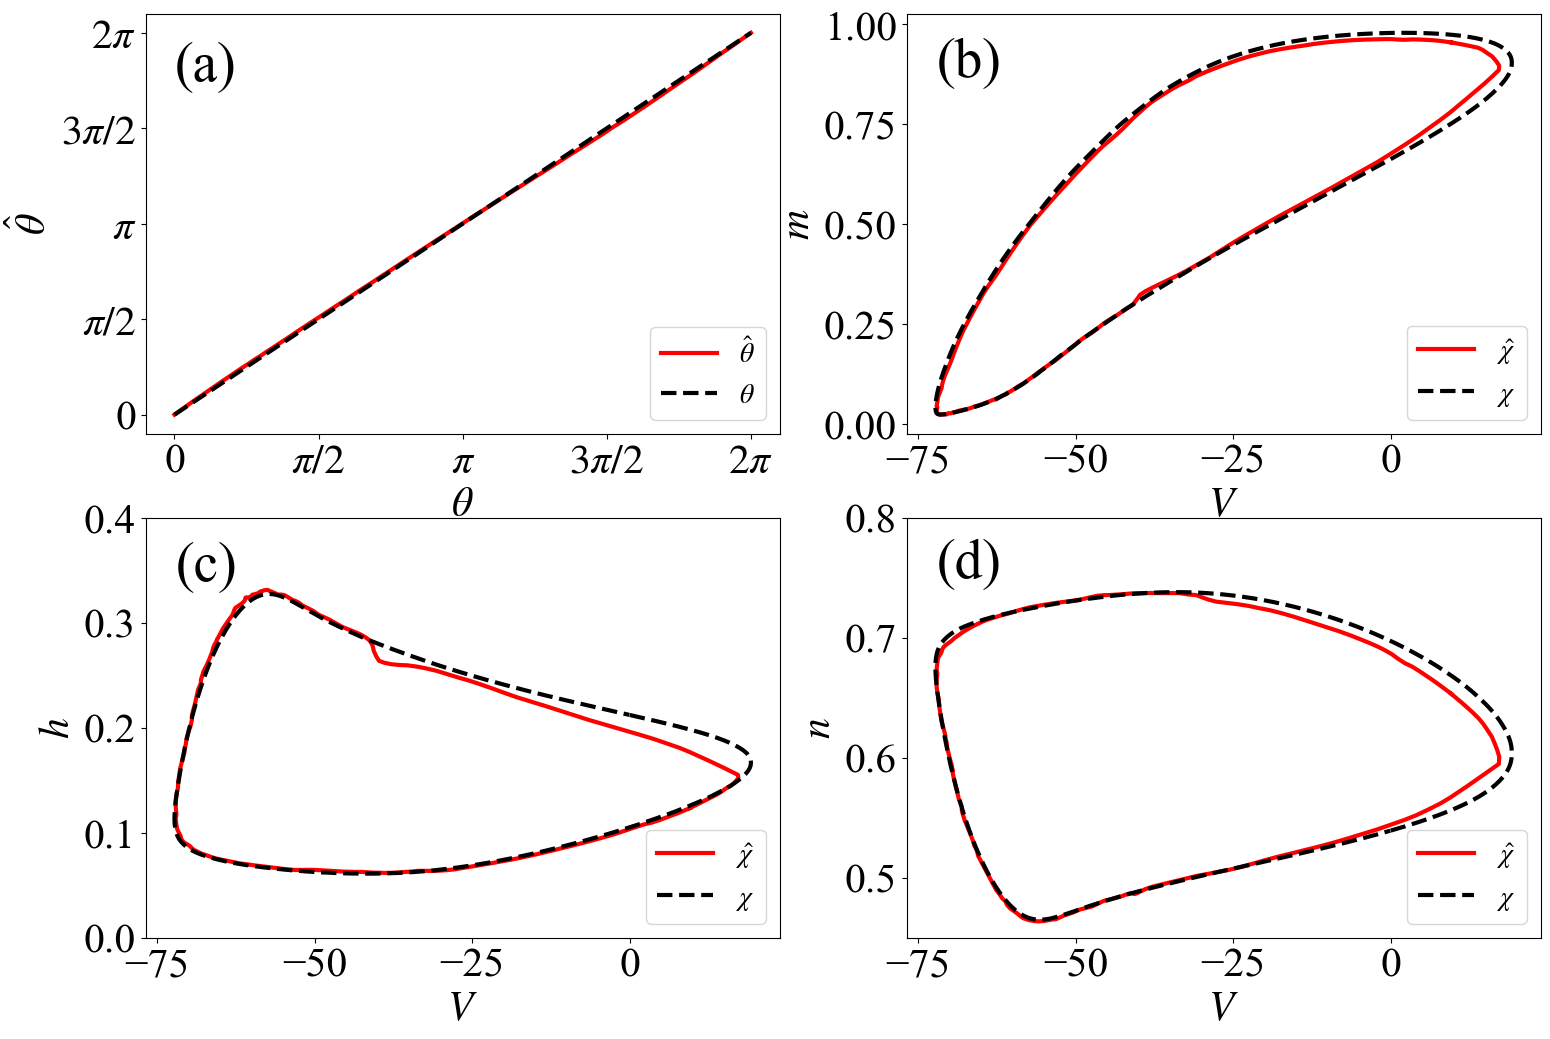

In [5]:
plt.figure(figsize=(18,12))
plt.subplot(2,2,1)
plt.plot(a,_ps, color = 'red',label=rf'$\hat \theta$',lw=3)
plt.plot(a,a, color = 'black',linestyle='dashed',label=rf'$\theta$',lw=3)
plt.xticks([0,0.5*np.pi,np.pi,1.5*np.pi,2*np.pi],\
               [r'0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'])
plt.yticks([0,0.5*np.pi,np.pi,1.5*np.pi,2*np.pi],\
               [r'0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'])
plt.text(0,5.5 ,'(a)',fontsize=40)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\hat{\theta}$')
plt.legend(loc='lower right',fontsize=20)
#plt.plot(a,a, color = 'black')
#plt.plot(a,_ps, color = 'red',linestyle='dashed')
plt.subplot(2,2,2)
plt.plot(eX0[:,0]*std[0]+mean[0],eX0[:,1]*std[1]+mean[1], color = 'red',lw=3,label=r'$\hat \chi$')
plt.plot(X0[:,0],X0[:,1],color='black',label=r'$\chi$',lw=3,linestyle='--')
plt.text(-72,0.87 ,'(b)',fontsize=40)
#plt.xlim(-1.7,1.7)
#plt.ylim(-1.5,1.5)
plt.xlabel(r'$V$')
plt.ylabel(r'$m$')
plt.legend(loc = 'lower right',fontsize=20)
plt.subplot(2,2,3)
plt.plot(eX0[:,0]*std[0]+mean[0],eX0[:,2]*std[2]+mean[2], color = 'red',lw=3,label=r'$\hat \chi$')
plt.plot(X0[:,0],X0[:,2],color='black',label=r'$\chi$',lw=3,linestyle='--')
plt.text(-72,0.34 ,'(c)',fontsize=40)
#plt.xlim(-1.7,1.7)
plt.ylim(0.0,0.4)
plt.xlabel(r'$V$')
plt.ylabel(r'$h$')
plt.legend(loc = 'lower right',fontsize=20)
plt.subplot(2,2,4)
plt.plot(eX0[:,0]*std[0]+mean[0],eX0[:,3]*std[3]+mean[3], color = 'red',lw=3,label=r'$\hat \chi$')
plt.plot(X0[:,0],X0[:,3],color='black',label=r'$\chi$',lw=3,linestyle='--')
plt.text(-72,0.75 ,'(d)',fontsize=40)
#plt.xlim(-1.7,1.7)
plt.ylim(0.45,0.8)
plt.xlabel(r'$V$')
plt.ylabel(r'$n$')
plt.legend(loc = 'lower right',fontsize=20)
plt.savefig(f'../figure/HH_LC.pdf')
plt.show()

In [6]:
grad = []
for i in range(len(X0)):
    x = [[(X0[i,k]-mean[k])/std[k] for k in range(X0.shape[1])]]
    x = torch.Tensor(x).to(device,dtype = torch.float)
    x.requires_grad = True
    p = to_polar(enc(x)[:, :2])
    p.backward()
    z = enc(x)
    grad.append(x.grad.detach().to('cpu').numpy()[0])

[[2.2012262745506574, 1.2828599746938019, -0.17684850514182995, -0.2478205324529378]]
0.3293575048446655


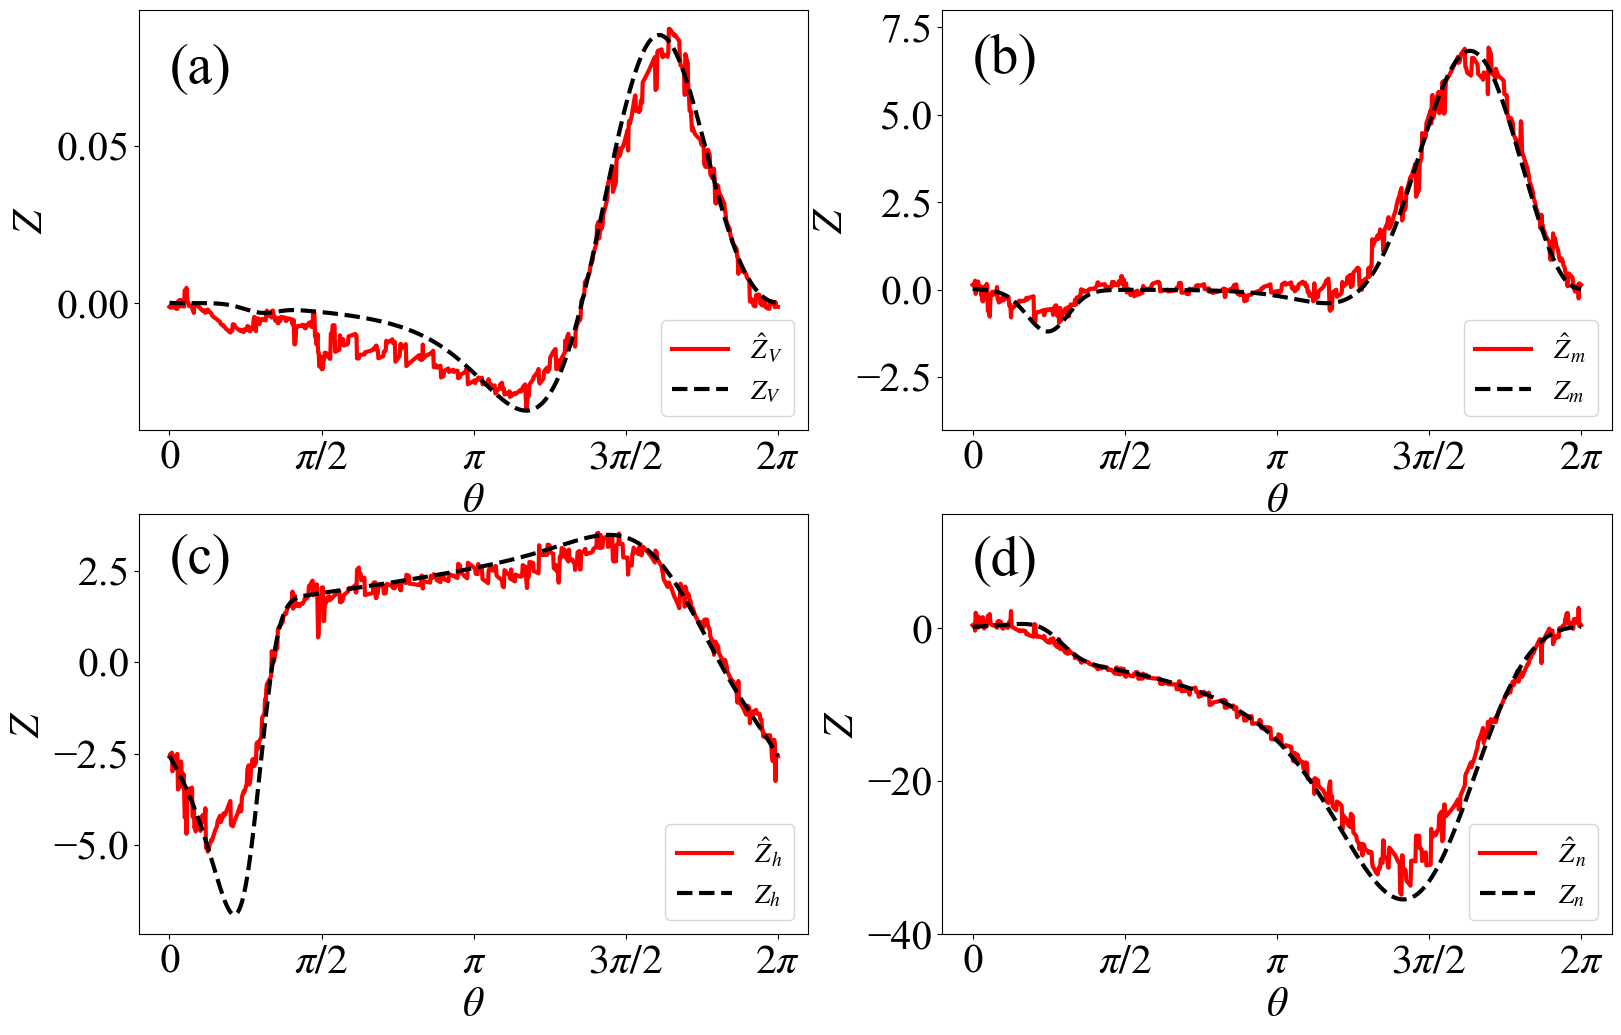

In [7]:
x = [[(X0[0,i]-mean[i])/std[i] for i in range(len(mean))]]
print(x)
x = torch.Tensor(x).to(device,dtype = torch.float)
x.requires_grad = True
z = enc(x)
p0 = to_polar(enc(x)[:,:2]).item()
print(p0)

xxx = ['V','m','h','n']

grad = []
nnn = 1000
for theta in np.linspace(0,2*np.pi,nnn):
    if w>0:
        _x = [[np.cos(theta+p0),np.sin(theta+p0),0]]
    else:
        _x = [[np.cos(-theta+p0),np.sin(-theta+p0),0]]
    _x = torch.Tensor(_x).to(device,dtype = torch.float)
    _x = dec(_x).detach().to('cpu').numpy()[0]
    _x = [_x[i] for i in range(len(_x))]
    #x = [[(X0[i,k]-mean[k])/std[k] for k in range(X0.shape[1])]]
    x = torch.Tensor([_x]).to(device,dtype = torch.float)
    x.requires_grad = True
    p = to_polar(enc(x)[:, :2])
    p.backward()
    z = enc(x)
    grad.append(x.grad.detach().to('cpu').numpy()[0])

plt.figure(figsize=(19,12))
xx  = np.linspace(0,2*np.pi,nnn)
for k in range(Z0.shape[1]):
    plt.subplot(2,2,k+1)
    if w>0:
        plt.plot(xx,[grad[i][k]/std[k] for i in range(nnn)],color='red',label=rf'$\hat Z_{xxx[k]}$',lw=3)
    else:
        plt.plot(xx,[-grad[i][k]/std[k] for i in range(nnn)],color='red',label=rf'$\hat Z_{xxx[k]}$',lw=3)
    if k==0:
        plt.text(0,0.07,'(a)',fontsize=40)
    if k==1:
        plt.text(0,6.2,'(b)',fontsize=40)
        plt.ylim(-4,8)
    if k==2:
        plt.text(0,2.45,'(c)',fontsize=40)
    if k==3:
        plt.text(0,7,'(d)',fontsize=40)
        plt.ylim(-40,15)
    plt.plot(np.linspace(0,2*np.pi,Z0.shape[0]),Z0[:,k],color='black',linestyle='--',label=rf'$Z_{xxx[k]}$',lw=3)
    plt.xticks([0,0.5*np.pi,np.pi,1.5*np.pi,2*np.pi],\
               [r'0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'])
    plt.xlabel(r'$\theta$')
    plt.ylabel(r'$Z$')
    plt.legend(loc='lower right',fontsize=20)
    #plt.savefig(f'Z{model}_x{k+1}.png', bbox_inches='tight')
#plt.savefig(f'Z{model}_x{k+1}.png', bbox_inches='tight')
plt.savefig(f'../figure/HH_PSF2.pdf', bbox_inches='tight')
plt.show()

In [8]:
def to_polar(x):
    theta = torch.atan2(x[:, 1], x[:, 0])
    return theta

class TrainedPhaseNet():
    def __init__(self):
        self.result_dir = f'../out/HH/'
        self.model_tag = ''
        self.input_dim = 4
        self.latent_dim = 3
        self.enc = Encoder(input_dim=self.input_dim, output_dim=self.latent_dim,hidden_dim = 100)
        self.dec = Decoder(input_dim=3,output_dim=4,hidden_dim = 100)
        enc_model_nm = os.path.join(self.result_dir,f'enc{self.model_tag}.pth')
        self.enc.to(device)
        self.dec.to(device)
        self.enc.load_state_dict(torch.load(enc_model_nm))
        dec_model_nm = os.path.join(self.result_dir,f'dec{self.model_tag}.pth')
        self.dec.load_state_dict(torch.load(dec_model_nm))
        self.enc.eval()
        self.dec.eval()
        
        lc_X0 = np.load(f'../data/limit_cycle_HH.npy')
        self.mean_X0 = lc_X0.mean(axis=0)
        self.std_X0 = lc_X0.std(axis=0)
        
        print(self.enc)

    def state2phase(self, x):
        x = [(x-self.mean_X0)/self.std_X0]
        x = torch.Tensor(x).to(device,dtype = torch.float)
        z = self.enc(x)
        p = to_polar(z[:, :2]).detach().to('cpu').item()
        return -p
    
    def phase2state(self, p):
        z = [[np.cos(p),np.sin(p)]+[0.0]*(self.latent_dim-2)]
        z = torch.Tensor(z).to(device,dtype = torch.float)
        out = self.dec(z)
        x = out.detach().to('cpu').numpy()*self.std_X0+self.mean_X0
        return x
    
    def get_later_state(self, x, dp):
        p = self.state2phase(x)
        later_state = self.phase2state(p+dp)
        return later_state

m = TrainedPhaseNet()

Encoder(
  (model): Sequential(
    (0): Linear(in_features=4, out_features=100, bias=True)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=100, out_features=100, bias=True)
    (4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=3, bias=True)
  )
)


In [9]:
from utils.limitcycle import func_HodgkinHuxley

def step(x,dt):
    k1 = np.array(func_HodgkinHuxley(0,x))
    k2 = np.array(func_HodgkinHuxley(0,x+k1*dt/2))
    k3 = np.array(func_HodgkinHuxley(0,x+k2*dt/2))
    k4 = np.array(func_HodgkinHuxley(0,x+k3*dt))
    return x+dt*(k1/6+k2/3+k3/3+k4/6)

In [10]:
i = 0
j = 4000
x1 = X0[i]
x2 = X0[j]
alpha = 0.05
e = 1.0#0.05

dt = 0.001
uvs1 = []
uvs2 = []
dps = []
ts = []
T = 10.127444444444444
for k,t in tqdm(enumerate(np.arange(0,120,dt)),total=int(120/dt)):
    x1 = step(x1,dt)
    x2 = step(x2,dt)

    p1 = m.state2phase(x1)
    p2 = m.state2phase(x2)
    
    if t>T*3:
        nuv1 = m.phase2state(p1+alpha) - m.phase2state(p1)
        nuv2 = m.phase2state(p2+alpha) - m.phase2state(p2)
        x1 += np.sin(p1-p2) * e * nuv1[0] * dt
        x2 += np.sin(p2-p1) * e * nuv2[0] * dt
    if k%int(1/dt/10)==0:
        ts.append(t)
        uvs1.append(x1)
        uvs2.append(x2)
        dps.append([p1,p2])

  0%|          | 0/120000 [00:00<?, ?it/s]C:\Users\Nishio\AppData\Local\Temp\ipykernel_15920\214745085.py:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:248.)
  x = torch.Tensor(x).to(device,dtype = torch.float)
100%|██████████| 120000/120000 [07:00<00:00, 285.05it/s]


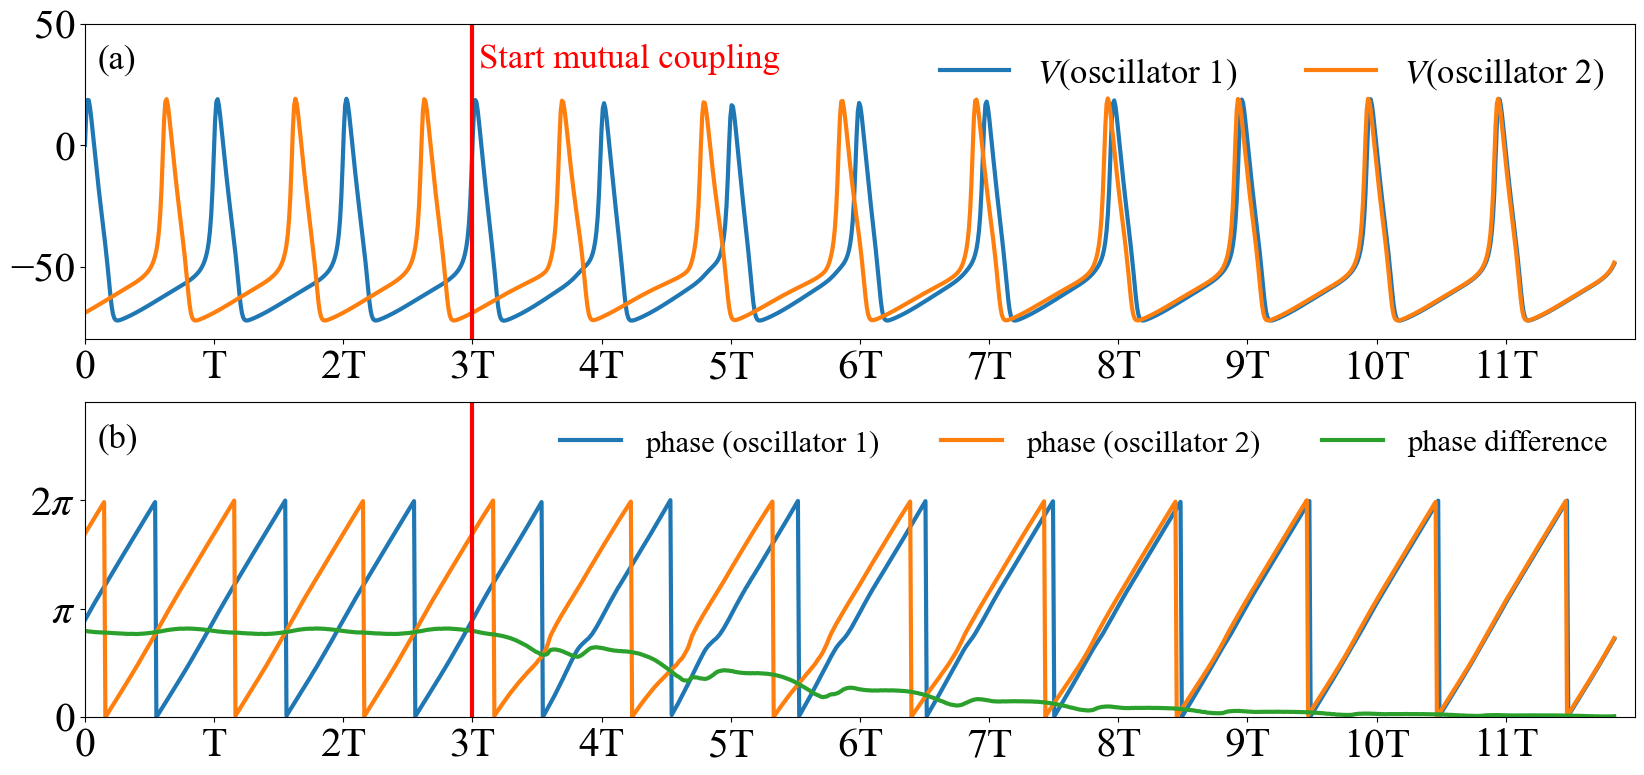

In [11]:
N = 12
rate = 1.0
plt.figure(figsize=(20,9))
plt.subplot(2,1,1)
s = int(len(dps)*rate)

plt.plot(ts,[uvs1[i][0] for i in range(s)],label=rf'$V$(oscillator 1)',lw=3)
plt.plot(ts,[uvs2[i][0] for i in range(s)],label=rf'$V$(oscillator 2)',lw=3)
plt.legend(ncol=2,frameon=False,fontsize=25,loc='upper right')
plt.vlines(x=3*T,ymin=-80,ymax=50,color='red',lw=3)
plt.ylim(-80,50)
plt.xlim(0,12*T)
plt.text(1.0,32 ,'(a)',fontsize=25)
plt.text(3.05*T,32 ,'Start mutual coupling',fontsize=25,color='red')
plt.xticks([0]+[T*i for i in range(1,N)],[0]+[rf'{i}T'if i!=1 else 'T' for i in range(1,N)])
plt.subplot(2,1,2)

plt.plot(ts,[dps[i][0] + np.pi for i in range(s)],label='phase (oscillator 1)',lw=3)
plt.plot(ts,[dps[i][1] + np.pi for i in range(s)],label='phase (oscillator 2)',lw=3)
plt.plot(ts,[(-dps[i][0]+dps[i][1]+0.1)%(2*np.pi)-0.1 for i in range(s)],label='phase difference',lw=3)

plt.legend(ncol=3,frameon=False,fontsize=22)
plt.text(1.0,7.8 ,'(b)',fontsize=25)

#plt.xlim(0,s)
plt.ylim(0,2.9*np.pi)
plt.xlim(0,12*T)
plt.vlines(x=3*T,ymin=0,ymax=3*np.pi,color='red',lw=3)
plt.yticks([0,np.pi,2*np.pi],\
               [r'0',r'$\pi$',r'$2\pi$'])
plt.xticks([0]+[T*i for i in range(1,N)],[0]+[rf'{i}T'if i!=1 else 'T' for i in range(1,N)])
plt.savefig(f'../figure/HH_SYNC.pdf', bbox_inches='tight')
plt.show()